<a href="https://colab.research.google.com/github/santansarah/barcode-scanner/blob/main/item_to_item_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is usually the Android part of my videos, but today, I'm here in Colab with my final model. I've gone ahead & run everything already so we don't have to wait for the scripts to execute. This way, I can just go through each block step by step.

First, I install everything that I'll need for this model. Most importantly, I'll be using the `tensorflow-recommenders` API to subclass my combined model and run the `Retrieval` task.




In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q tensorflow-datasets
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 8.0 MB/s eta 0:00:00


Then I add all of my imports.

In [ ]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow import keras
from keras.models import Sequential
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.12.0


I uploaded my Open Food Facts CSV file to Google Drive, so I could easily acess it from Colab. In this block, I connect to drive, and create a symbolic link so I can access it as `/mydrive`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


Let's go head an take a look at this file, before we start the preprocessing steps:
https://drive.google.com/file/d/18FOEN6thUGgZx-8WdeA74YQRp4I1BLiJ/view?usp=sharing

This is a handy function to clean my CSV file. As we saw, some of the fat & carb values are floats, so I round them to solid Integers. I also drop any null data.

In [ ]:
def pre_process(df_data):
    ## check NaNs and drop rows if any
    print(df_data.isnull().sum())
    df_data.dropna(inplace=True)
    df_data["fat_value"] = df_data["fat_value"].round(0).astype(int)
    df_data["carbohydrates_value"] = df_data["carbohydrates_value"].round(0).astype(int)
    return df_data

Now, I load up my data with Pandas. One small, tricky thing here - and yet very important, is that the `code` column imports as an Integer by default. This is a HUGE problem, because this drops the two 0's in front of some of the barcodes. That means that when I pass in a barcode from my Android app, they won't match, and the datatypes will be different. I easily got around this by specifying the `dtype` of `str` for the `code` column.

In [ ]:
barcodes_df = pd.read_csv('/mydrive/food_data/food-final.csv', dtype={'code': str}) 
barcodes_df = pre_process(barcodes_df.filter(['code', 'product_name_en', 'fat_value', 'carbohydrates_value']))

code                     0
product_name_en         31
fat_value              395
carbohydrates_value    388
dtype: int64


Once the data's all loaded, I create my custom `food_diet_type` column. This block is slightly different than the example from my earlier slide. After learning more about feature preprocessing and Text embeddings, I decided to make the diet type a numeric categorical range from `1-5`.

In [ ]:
conditions = {
    1: (barcodes_df['carbohydrates_value'] >= 30),
    2: (barcodes_df['fat_value'] >= 5) & (barcodes_df['carbohydrates_value'] <= 12),
    3: (barcodes_df['fat_value'] <= 1) & (barcodes_df['carbohydrates_value'] <= 1),
    4: (barcodes_df['fat_value'] <= 3)
}
barcodes_df['food_diet_type'] = np.select(conditions.values(), conditions.keys(), default=5).astype(int)

Here's how the final preprocessed data looks:

In [ ]:
print(len(barcodes_df))
barcodes_df

3303


,code,product_name_en,fat_value,carbohydrates_value,food_diet_type
0,0078742367194,Omega -3 trail mix,44,33,1
1,0078742370828,Complete pancake & waffle mix,3,74,1
2,0078742082752,Chunk Light Tuna In Water,1,0,3
4,0078742371825,Brown Gravy Mix,8,50,1
5,0078742144603,Naturally & Artificially Fruit-Flavored Snacks,2,77,1
...,...,...,...,...,...
3697,0078742136288,"Organic great value, fruit spread, strawberry",0,58,1
3698,0099482454494,Great Northern Beans,1,63,1
3699,0099482452759,Great Northern Beans,0,15,4
3700,0078742065007,"Great value, frosted toaster pastries, cherry",10,71,1


Next, I create my training, validation, and test dataframes from my food data import. There are so many ways to do this - np.split was really easy, and works OK for this model. This method allocates about 80% of the data to the training dataset, and about 10% to the validation and test datasets. I think I need to revisit this later, and definitely add more data to my validation and test datasets, but for now, this works fine.

In [ ]:
train, val, test = np.split(barcodes_df.sample(frac=1), [int(0.8*len(barcodes_df)), int(0.9*len(barcodes_df))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2642 training examples
330 validation examples
331 test examples


To fit my model, these dataframes then need to be converted to tensor datasets.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(dict(train))
test_ds = tf.data.Dataset.from_tensor_slices(dict(test))
val_ds = tf.data.Dataset.from_tensor_slices(dict(val))

Here, I get a list of only the barcodes, just like Movie Titles from the TensorFlow tutorial.

In [ ]:
barcodes = train_ds.map(lambda x: x["code"])

In [ ]:
len(barcodes)

2642

Now, I prepare for my Embedding layers by getting all of my unique features, which in my case is:
- Barcodes as String
- Fat Value as Int
- Carbohydrates Value as Int
- Food Diet Types as Int

In [ ]:
unique_barcodes = np.unique(np.concatenate(list(barcodes.batch(500))))
print(unique_barcodes)

unique_user_fat = tf.range(1,200)
 
unique_user_carbs = tf.range(1,200)
print(unique_user_carbs)

unique_diet_types = tf.range(1,6)
print(unique_diet_types)

[b'000158230404573973194' b'0008749315577' b'0012142013718' ...
 b'87421415' b'87545463' b'915732']
tf.Tensor(
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199], shape=(199,), dtype=int32)
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


At this point, I'm ready to build my models. The TensorFlow MovieLens Tutorial just creates a simple `user_model`:

```
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])
```

But since I needed to add several embedding layers, here, I inherit from `tf.keras.Model`. This ItemModel includes all of the item features that I want my model to consider during the retrieval process. In this model, I use my unique feature arrays to create my Sequential Embeding layers. The barcode is a StringLookup, and the rest are IntegerLookups.

In [ ]:
class ItemModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.item_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_barcodes, mask_token=None),
        tf.keras.layers.Embedding(len(unique_barcodes) + 1, 32),
    ])

    # Just to note - order is important here! When I had diet_type
    # below fat & carbs, it made a difference. I still need to learn
    # about weights, and how I can build better relationships between
    # my features.
    self.diet_type_embedding = tf.keras.Sequential([
          tf.keras.layers.IntegerLookup(
              vocabulary=unique_diet_types, mask_token=None),
          tf.keras.layers.Embedding(len(unique_diet_types) + 1, 32),
      ]) 

    self.fat_embedding = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_user_fat, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_fat) + 1, 32),
    ])

    self.carbs_embedding = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_user_carbs, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_carbs) + 1, 32),
    ])

  def call(self, inputs):
    return tf.concat([
        self.item_embedding(inputs["code"]),
        self.diet_type_embedding(inputs["food_diet_type"]),
        self.fat_embedding(inputs["fat_value"]),
        self.carbs_embedding(inputs["carbohydrates_value"])
    ], axis=1)

Next, I expand on my ItemModel to create a deeper retrieval model. This QueryModel adds the emedding layers by calling `self.embedding_model = ItemModel()`, then, it adds the Dense layers, and sets their activation to `relu`. This can help capture complex relationships between my features - hopefully fat & carbs! `layer_sizes` is a parameter, so I can experiment with deeper model sizes, for example I could start with [32], then [64,32], then try [128, 64, 32]. So far though, my initial tests show that creating a deeper model doesn't come back with great results - this might be because my dataset is too small, and I'm **overfitting**. But for now, I'm leaving it here in case I want to expand, and continue to experiment.

In [ ]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""
 
  def __init__(self, layer_sizes):
    """Model for encoding user queries.
 
    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()
 
    # We first use the item model for generating embeddings.
    self.embedding_model = ItemModel()
 
    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()
 
    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
 
    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
     
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)
  

This next block creates the embedding layer for the Candidate model, which in my case is the list of barcodes from my CSV. Embedding layers convert raw values to usable, trainable formats. Here, I add a `barcode_vectorizer` - this step is really important, so that I'm able to pass a raw string from my Android app. Otherwise, if the TextVectorization did not occur in the model, I believe I'd have to export ALL of the integer barcode mappings to a JSON file. Then, I'd have to include that JSON file in my app or serve it up from an API, and lookup the corresponding barcode-to-integer values. This is one of those lessons that I had to learn the hard way, when I was using my `food_diet_type` as a string in one of my earlier models. 🤪

In [ ]:
class BarcodeModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.barcode_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_barcodes, mask_token=None),
      tf.keras.layers.Embedding(len(unique_barcodes) + 1, 32)
    ])

    # Here I set up the vectorizer 
    self.barcode_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    # Then I create the text embedding
    self.barcode_text_embedding = tf.keras.Sequential([
      self.barcode_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    # And by calling adapt on the unique list of barcodes here
    # inside the model, I believe this is the final step that
    # allows me to pass a regular string array from Android.
    self.barcode_vectorizer.adapt(barcodes)

  def call(self, barcodes):
    return tf.concat([
        self.barcode_embedding(barcodes),
        self.barcode_text_embedding(barcodes),
    ], axis=1)

Similar to the QueryModel, this model just combines the embedding layers w/the deeper Dense layers.

In [ ]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""
 
  def __init__(self, layer_sizes):
    """Model for encoding movies.
 
    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()
 
    self.embedding_model = BarcodeModel()
 
    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()
 
    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
 
    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
     
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)
  

Now it's time to combine everything together, into one final model. This model sets up the QueryModel, the CandiateModel, and defines the Retrieval task. Let's say we pass a barcode of 888. When using FactorizedTopK metrics, the model will check to see how often that same barcode is returned in the retrieval query. This helps determine the model's categorical accuracy.



In [ ]:
class RecommendModel(tfrs.models.Model):
 
  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=barcodes.batch(128).map(self.candidate_model),
        ),
    )
 
  # This is the loss function that defines the embeddings, then returns
  # the retrieval task.
  def compute_loss(self, features, training=False):
 
    query_embeddings = self.query_model({
        "code": features["code"],
        "food_diet_type": features["food_diet_type"],  
        "fat_value": features["fat_value"],
        "carbohydrates_value": features["carbohydrates_value"]
    })
    candidate_embeddings = self.candidate_model(features["code"])
 
    return self.task(
        query_embeddings, candidate_embeddings, compute_metrics=not training)

Caching the training dataset improves performance, allowing the second interation over the dataset to be much faster than the first one. If you cache your training set, make sure that you also cache your test and validation datasets or you might have issues when you fit your model.

In [ ]:
cached_train = train_ds.shuffle(len(train_ds)).batch(500).cache()
cached_test = test_ds.batch(50).cache()
cached_val = val_ds.batch(50).cache()

With everything set up, it's time to create and use the combined model. 

In [ ]:
# Here, I go ahead and instantiate a shallow model. Then I compile it.
model = RecommendModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

# Next, I fit the model with my cached datasets. 
model.fit(cached_train, epochs=50, validation_data=cached_val)

# When it's done, it will print out my TopK accuracy scores. I don't think 
# that I'm getting good evaluation numbers yet - I think that's because I'm
# not working with enough data yet. This is something I need to revisit in the
# future.
train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/50
6/6 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 2420.5639 - regularization_loss: 0.0000e+00 - total_loss: 2420.5639 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 102.0359 - val_regularization_loss: 0.0000e+00 - val_total_loss: 102.0359
Epoch 2/50
6/6 [==============================] - 1s 261ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy:

This next block creates a BruteForce index layer, which inherits from TopK. I pass my QueryModel to the constructor, which allows the index to accept _raw feature values_. This means I can pass in data to the index without worrying about String or Interger Lookup conversions. The BruteForce index layer returns a _Tuple of (top candidate scores, top candidate identifiers)_, for example a float value of 17.677254, which is the top K score, and the recommended barcode, as a string. I pass in the barcodes dataset to build the retrieval index. Something that's very important - which again, is something that I learned the hard way - is that this index is what you actually save when you save the model. So basically, this last BruteForce index layer becomes your final model. 

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
# recommends barcodes out of the entire barcodes dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((barcodes.batch(100), barcodes.batch(100).map(model.candidate_model)))
)

With the index created, you can now use it to pass in your own query, independent of the training dataset. Here, I pass in a keto barcode, with a fat value of 15, and a carb value of 2. Earlier, I mentioned that the BruteForce Index returns of tuple of scores & barcodes. Here's where we can see what this looks like - and this is really important, because I'll need to handle this _output_ from my Android app.

When I call the index, I can create my scores & barcode variables. Here, I just print out the scores. Notice how they are listed in decending order...based on what the model thinks is a good match.

Then, I can iterate through the `barcodeRecommendations` and map the recommended barcodes to my training dataset, so I can see what type of products my model is recommending.

In [ ]:
# Get recommendations.
scores, barcodeRecommendations = index({
    "code": np.array(["0078742028613"]),
    "fat_value": np.array([15]),
    "carbohydrates_value": np.array([7]),
    "food_diet_type": np.array([2])})

print(scores)

results = list(barcodeRecommendations[0].numpy().astype('str'))

for x in results:
  my_filtereddataset = train_ds.filter(lambda a: a['code'] == x)
  print(next(iter(my_filtereddataset)))

tf.Tensor(
[[15.90346  15.740753 15.576517 14.641495 14.299671 13.997471 13.649216
  13.423485 13.198267 12.905101]], shape=(1, 10), dtype=float32)
{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0628915362343'>, 'product_name_en': <tf.Tensor: shape=(), dtype=string, numpy=b'Tartinade \xc3\xa0 fromage \xc3\xa0 la cr\xc3\xa8me l\xc3\xa9g\xc3\xa8re'>, 'fat_value': <tf.Tensor: shape=(), dtype=int64, numpy=13>, 'carbohydrates_value': <tf.Tensor: shape=(), dtype=int64, numpy=7>, 'food_diet_type': <tf.Tensor: shape=(), dtype=int64, numpy=2>}
{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0078742194639'>, 'product_name_en': <tf.Tensor: shape=(), dtype=string, numpy=b'Turkey Breast'>, 'fat_value': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'carbohydrates_value': <tf.Tensor: shape=(), dtype=int64, numpy=7>, 'food_diet_type': <tf.Tensor: shape=(), dtype=int64, numpy=4>}
{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0078742163536'>, 'product_name_en': <tf.Tensor: shape=(), dty

All of those embedding layers, dense layers, and separate models can get pretty confusing. It would be great if we could call `model.summary()` to see what everything looks like, but I wasn't able to get that to work with this structure, even when I tried to call it after `model.fit`. What I can do is call `index.summary()` though. This gives us a little bit of info on the QueryModel. The parameters are all of my learnable features that the layer will weigh and evaluate during training.

In [ ]:
index.summary()

Model: "brute_force"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 query_model (QueryModel)    multiple                  101696    
                                                                 
Total params: 188,882
Trainable params: 101,696
Non-trainable params: 87,186
_________________________________________________________________


`plot_model` is another way to visualize a model, but unfortunately for an index, I only get an image that says `brute_force`, with no other information.

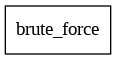

In [ ]:
keras.utils.plot_model(index, show_shapes=True, show_dtype=True, expand_nested=True, show_trainable=True) 

That's pretty much it for creating the model - now, it's time to save it. First, I simply call `index.save`. If you try to do something like `model.save(path)`, you'll get an error - with this structure, I can only save the index. 

Instead of a temp or nested directory, I like to use a `./models` path, so the output file saves right to my Colab root directory; it's much easier to find it this way.

In [ ]:
import tempfile
import os
# Export the query model.

path = "./models/product_recs"
print(path)

index.save(path)


./models/product_recs


Next, I load up the saved index, and try it out. This time, I'll pass in a high carb diet type, and see what comes back.

In [ ]:
# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a food type in, get top predicted barcodes back.
_, barcodeRecommendations = loaded({
    "code": np.array(["0078742370828"]),
    "fat_value": np.array([3]),
    "carbohydrates_value": np.array([74]),
    "food_diet_type": np.array([1])})

results = list(barcodeRecommendations[0].numpy().astype('str'))

for x in results:
  my_filtereddataset = train_ds.filter(lambda a: a['code'] == x)
  print(next(iter(my_filtereddataset)))

{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0078742370828'>, 'product_name_en': <tf.Tensor: shape=(), dtype=string, numpy=b'Complete pancake & waffle mix'>, 'fat_value': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'carbohydrates_value': <tf.Tensor: shape=(), dtype=int64, numpy=74>, 'food_diet_type': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0078742285481'>, 'product_name_en': <tf.Tensor: shape=(), dtype=string, numpy=b"Brown 'N Serve Dinner Rolls">, 'fat_value': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'carbohydrates_value': <tf.Tensor: shape=(), dtype=int64, numpy=52>, 'food_diet_type': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'code': <tf.Tensor: shape=(), dtype=string, numpy=b'0078742183923'>, 'product_name_en': <tf.Tensor: shape=(), dtype=string, numpy=b'Awake fruit yogurt cereal'>, 'fat_value': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'carbohydrates_value': <tf.Tensor: shape=(), dtype=int64, numpy=84>, '

`index.save` saves the model as a TensorFlow SavedModel, which we won't be able to use in Android yet. Next, we need to convert that SavedModel to a TensorFlow Lite model. Here, I faced another issue the first time around - I found that I needed to add TensorFlow ops support. Here's the error:

```
ConverterError: <unknown>:0: error: loc(fused["HashTableV2:", "hash_table"]): 'tf.HashTableV2' op is neither a custom op nor a flex op
```

This is because of my IntegerLookups. Behind the scenes, the IntegerLookup embedding layers create a mapped table, which isn't included in the TensorFlow Lite builtin operator library. Luckily there's a workaround; I just needed to add the right converter options, and I was good to go.
>Important: You'll need to add additional Android dependencies because of this issue too. I'll go over that once I'm finished with these last few steps in my Colab. 

For more information, you can check out this link: https://www.tensorflow.org/lite/guide/ops_select.






In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model.
with open(path + '/product_recs.tflite', 'wb') as f:
  f.write(tflite_model)

Now that the hard part is done, it's time for some even harder stuff. I'm just kidding; sort of - this part is kinda fun. Once you download your TensorFlow Lite file, there's this awesome app called **Netron** that lets you visualize your model.

Once it's loaded up, you can see:
* Your inputs
* Input datatypes
* Input order - which is awesome
* Outputs
* Output datatypes
* Output order

This information is a must to know when we're ready to start sending and receiving inputs and outputs from our Android app. You can also see the HashTables that are created for the IntegerLookups, the BruteForce TopK layer, and all sorts of cool stuff. To the developers of Netron, I just want to say awesome job, and many thanks for this amazing tool. 

Here's the link for more information: https://github.com/lutzroeder/netron

********
In addition to Netron, we can also get an idea of how Android will handle _inputs_ and _outputs_ by using the TensorFlow Lite Interpreter. Here, I read my tflite file, then get the details about my inputs and outputs. Next, I use `interpreter.set_tensor` to set my input values. This is similar to how I used the `index` to get recommendation, but for the interpreter, I'm not using names. Instead, I use the input index, and send my inputs in the order they appear in the Netron preview. 

For the outputs, it's just like the index - the interpreter will bring back the scores & the barcode recommendations.

My Android app also uses the TensorFlow Lite interpreter; so this is a really good preview of how things are going to work inside the app.

In [ ]:
path = "./models/product_recs"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=path + '/product_recs.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("input details...")
print(input_details)
print(output_details)


# Set inputs in order from 0 - 3. Use Netron to help. This will
# be the same output array /android.
interpreter.set_tensor(input_details[0]['index'], np.array([2], dtype=np.int64))
interpreter.set_tensor(input_details[1]['index'], np.array([15], dtype=np.int64))
interpreter.set_tensor(input_details[2]['index'], np.array([7], dtype=np.int64))
interpreter.set_tensor(input_details[3]['index'], np.array(["0078742028613"], dtype=str))

interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index'])
print("scores...")
print(scores)
output_data = interpreter.get_tensor(output_details[1]['index'])
print("recommendations...")
print(output_data)


input details...
[{'name': 'serving_default_food_diet_type:0', 'index': 0, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_fat_value:0', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_carbohydrates_value:0', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array

Another handy tool is the TensorFlow Lite Analyzer. This by far gives us the most detail from Python. Here we can see the input shapes for the embedding layers, and dive a little deeper into the structure.

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path=path + '/product_recs.tflite')


=== ./models/product_recs/product_recs.tflite ===

Your TFLite model has '2' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CALL_ONCE op takes
 as input and produces  as output.

Subgraph#0 main(T#0, T#1, T#2, T#3) -> [T#29, T#31]
  Op#0 CALL_ONCE(Subgraph#1) -> []
  Op#1 FlexHashTableV2() -> [T#14]
  Op#2 FlexHashTableV2() -> [T#15]
  Op#3 FlexHashTableV2() -> [T#16]
  Op#4 FlexHashTableV2() -> [T#17]
  Op#5 FlexLookupTableFindV2(T#14, T#2, T#12) -> [T#18]
  Op#6 GATHER(T#7, T#18) -> [T#19]
  Op#7 FlexLookupTableFindV2(T#17, T#3, T#12) -> [T#20]
  Op#8 GATHER(T#8, T#20) -> [T#21]
  Op#9 FlexLookupTableFindV2(T#15, T#1, T#12) -> [T#22]
  Op#10 GATHER(T#9, T#22) -> [T#23]
  Op#11 FlexLookupTableFindV2(T#16, T#0, T#12) -> [T#24]
  Op#12 GATHER(T#10, T#24) -> [T#25]
  Op#13 CONCATENATION(T#21, T#25, T#23, T#19) -> [T#26]
  Op#14 FULLY_CONNECTED(T#26, T#13, T#4) -> [T#27]
  Op#15 FULLY_CONNECTED(T#27, T#5, T#-1) -> [T#28]
 

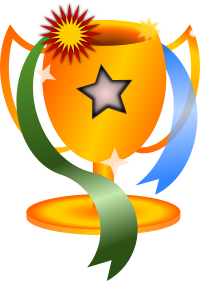

And finally, I've won the first half of the fight, and my model coding is done! 
Now, it's time to import the model into Firebase. You can do this automatically if you'd like to, which would be awesome for an automated, CI/CD pipeline. There are quite a few steps involved though, so for me, it was just easier to download the tflite file. If you'd like to learn more about the Firebase ML SDK, check out this link:

https://colab.research.google.com/github/firebase/quickstart-python/blob/master/machine-learning/Firebase_ML_API_Tutorial.ipynb